In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import csv
import dill
import glob
import itertools
import json
import math
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Times New Roman'
import matplotlib.patches as mpatches
from matplotlib.ticker import FormatStrFormatter
import numpy as np
from os.path import exists
import pandas as pd

import sys
sys.path.append("../scripts/")
import process_res as pr

Read processed data or process and saveinformation from log files

In [6]:
dfs = {}

if exists('df_25.pkl'):
    dfs[0] = pd.read_pickle('df_25.pkl')
else:
    df_25 = pr.read_data('../scripts/parameters/parameters25.json')
    df_25.to_pickle('df_25.pkl')
    dfs[0] = df_25

if exists('df_5.pkl'):
    dfs[1] = pd.read_pickle('df_5.pkl')
else:
    df_5 = pr.read_data('../scripts/parameters/parameters05.json')
    df_5.to_pickle('df_5.pkl')
    dfs[1] = df_5
    
if exists('df_75.pkl'):
    dfs[2] = pd.read_pickle('df_75.pkl')
else: 
    df_75 = pr.read_data('../scripts/parameters/parameters75.json')
    df_75.to_pickle('df_75.pkl')
    dfs[2] = df_75

p_vals = [0.25, 0.5, 0.75]

Plot comparison with Gurobi MIP versus CCP + DNeal

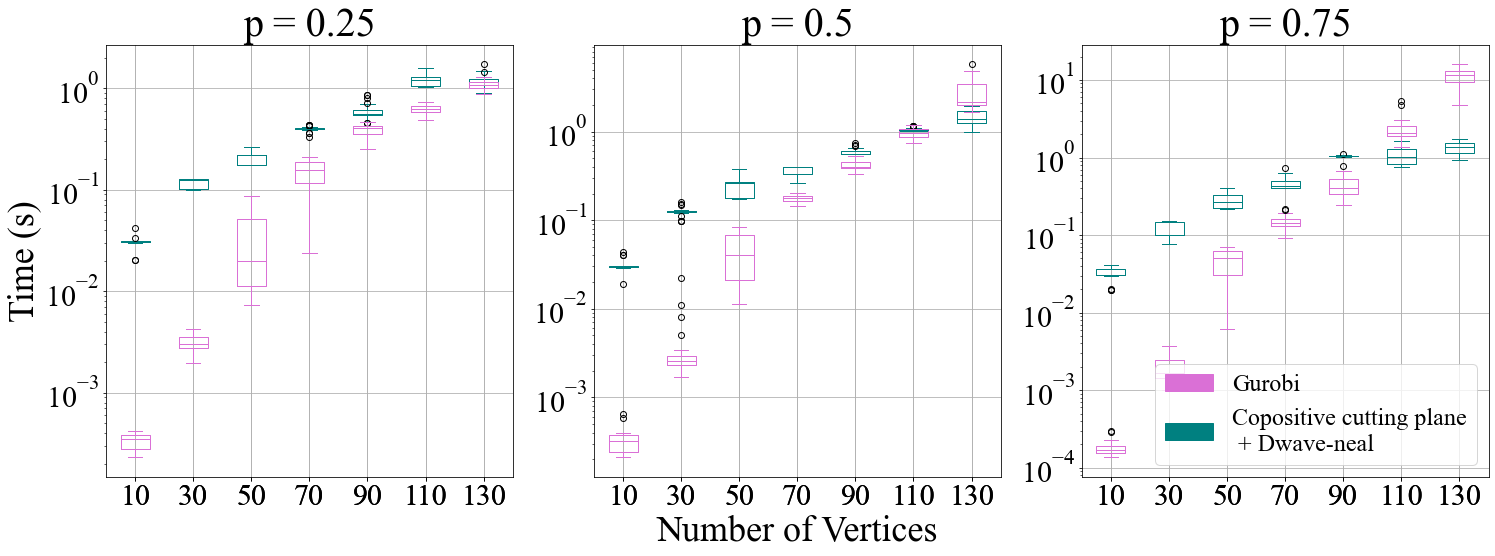

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(24, 8))
for idx in range(3):
    df = dfs[idx]
    ax = axs[idx]
    p = p_vals[idx]
    df.boxplot(column = 'full_time_neal', by = 'n', ax=ax, color='teal')
    df.boxplot(column = 'gp_mult_time', by='n', ax=ax, color='orchid')
    
    ax.set_yscale('log')
    ax.set_xlabel('')
    ax.set_title('p = {}'.format(p), fontsize=40)
    ax.tick_params(axis='both', which='major', labelsize=30)
    if idx == 1:
        ax.set_xlabel('Number of Vertices', fontsize=36)
    if idx == 0:
        ax.set_ylabel('Time (s)', fontsize=36)
    
fig.suptitle('')
purple_patch = mpatches.Patch(color='orchid', label='Gurobi')
green_patch = mpatches.Patch(color='teal', label='Copositive cutting plane\n + Dwave-neal')
plt.legend(handles=[purple_patch, green_patch], fontsize=24)
plt.savefig('../plots/ccpNeal_gurobi.pdf')

Plot Gurobi MIP, ccp + neal, and dwave max clique solution time

/home/robin/anaconda3/envs/ccp_mc/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robin/anaconda3/envs/ccp_mc/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


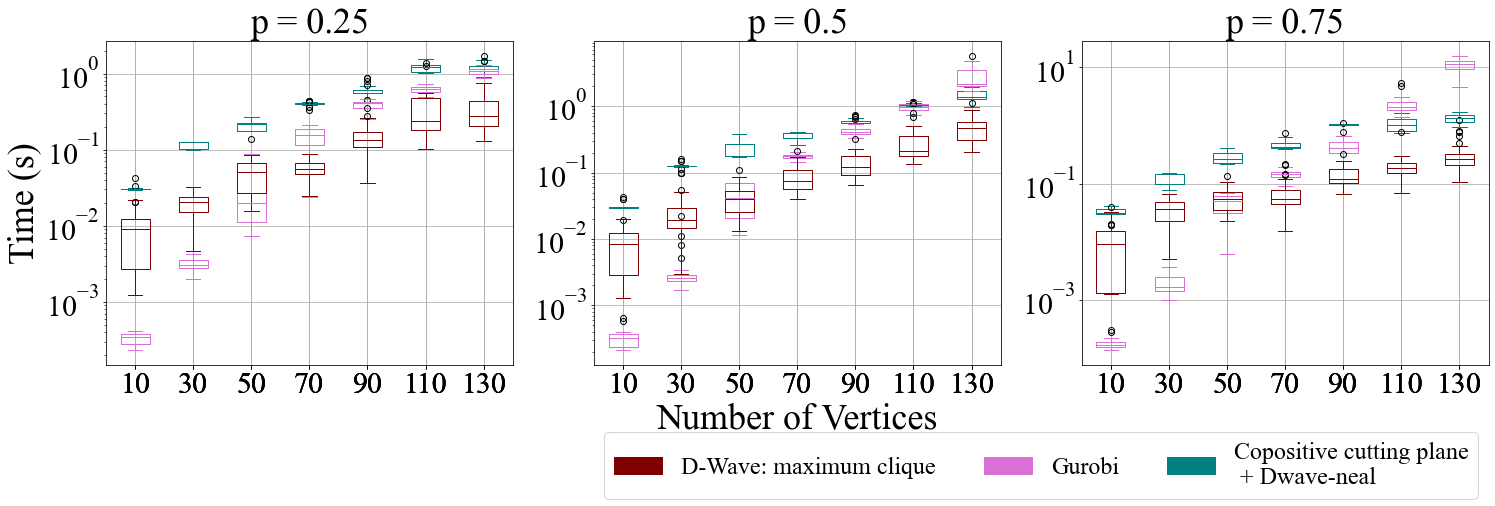

In [12]:
def expand_penalty(df_old):
    record = []
    rows =[]
    for _, row in df_old.iterrows():
        N, n, p, n_grid, gp_add_time, gp_mult_time = row['N'], row['n'], row['p'], row['ngrid'],\
        row['gp_add_time'], row['gp_mult_time']
        ss_list = row['ss_list']
        vcc_list = row['vcc_list']
        for idx, penalty_exp in enumerate(range(-1, 5)):
            penalty = 2**penalty_exp

            ss = ss_list[idx] #ss = samplesize
            if ss is None:
                continue
            ss_scaled = ss / row['GT_val']

            vcc = vcc_list[idx]
            valid_gs = vcc * (ss == row['GT_val'])

            mean_time = np.mean(row['t_list'][idx])
            
            def tts_999(vgs):
                if vgs == 1.:
                    return mean_time
                elif vgs <= 0.:
                    return 1e6
                else:
                    return mean_time * np.log(1 - 0.999) / np.log(1 - vgs)
            
            record.append((N, n, p, penalty, n_grid, gp_add_time, gp_mult_time,\
                           np.mean(ss_scaled), np.mean(vcc),\
                           np.mean(valid_gs),mean_time, tts_999(np.mean(valid_gs))))
    df = pd.DataFrame.from_records(record,\
                        columns = ['N', 'n','p', 'penalty', 'ngrid', 'gp_add_time',\
                                   'gp_mult_time', 'ss', 'vcc', 'gs_frac','mean_t', 'tts_999'])
    return df, rows
pen_idxs = [0]
fig, axs = plt.subplots(len(pen_idxs), 3, figsize=(24, 6 * len(pen_idxs)))
for idx_p in range(3):
    for idx_pen in pen_idxs:
        df = dfs[idx_p]
        if len(pen_idxs) == 1:
            ax = axs[idx_p]
        else:
            ax = axs[idx_pen, idx_p]
        p = p_vals[idx_p]
        df.boxplot(column = 'full_time_neal', by = 'n', ax=ax, color='teal')
        df.boxplot(column = 'gp_mult_time', by='n', ax=ax, color='orchid')

        df, rows = expand_penalty(df)
        penalty = 2**idx_pen
        df_pen= df[df['penalty']==penalty]
        df_pen.boxplot(column='tts_999', by='n', ax=ax, color = 'maroon')


        ax.set_yscale('log')
        ax.set_xlabel('')
        ax.set_title('p = {}'.format(p, penalty), fontsize=36)
        if idx_p == 1:
            ax.set_xlabel('Number of Vertices', fontsize=36)
        if idx_p == 0:
            ax.set_ylabel('Time (s)', fontsize=36)
        
        ax.tick_params(axis='both', which='major', labelsize=30)
    fig.suptitle('')
    mar_patch = mpatches.Patch(color='maroon', label='D-Wave: maximum clique')
    purple_patch = mpatches.Patch(color='orchid', label='Gurobi')
    green_patch = mpatches.Patch(color='teal', label='Copositive cutting plane\n + Dwave-neal')
plt.legend(handles=[mar_patch, purple_patch, green_patch], fontsize=24, loc = 'lower center', bbox_to_anchor=(-.1, -0.45), ncol=3)
plt.savefig('../plots/ccpNeal_gurobi_mc.pdf', bbox_inches='tight')

Plot sensitivity of Dwave max clique to penalty parameter

/home/robin/anaconda3/envs/ccp_mc/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robin/anaconda3/envs/ccp_mc/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


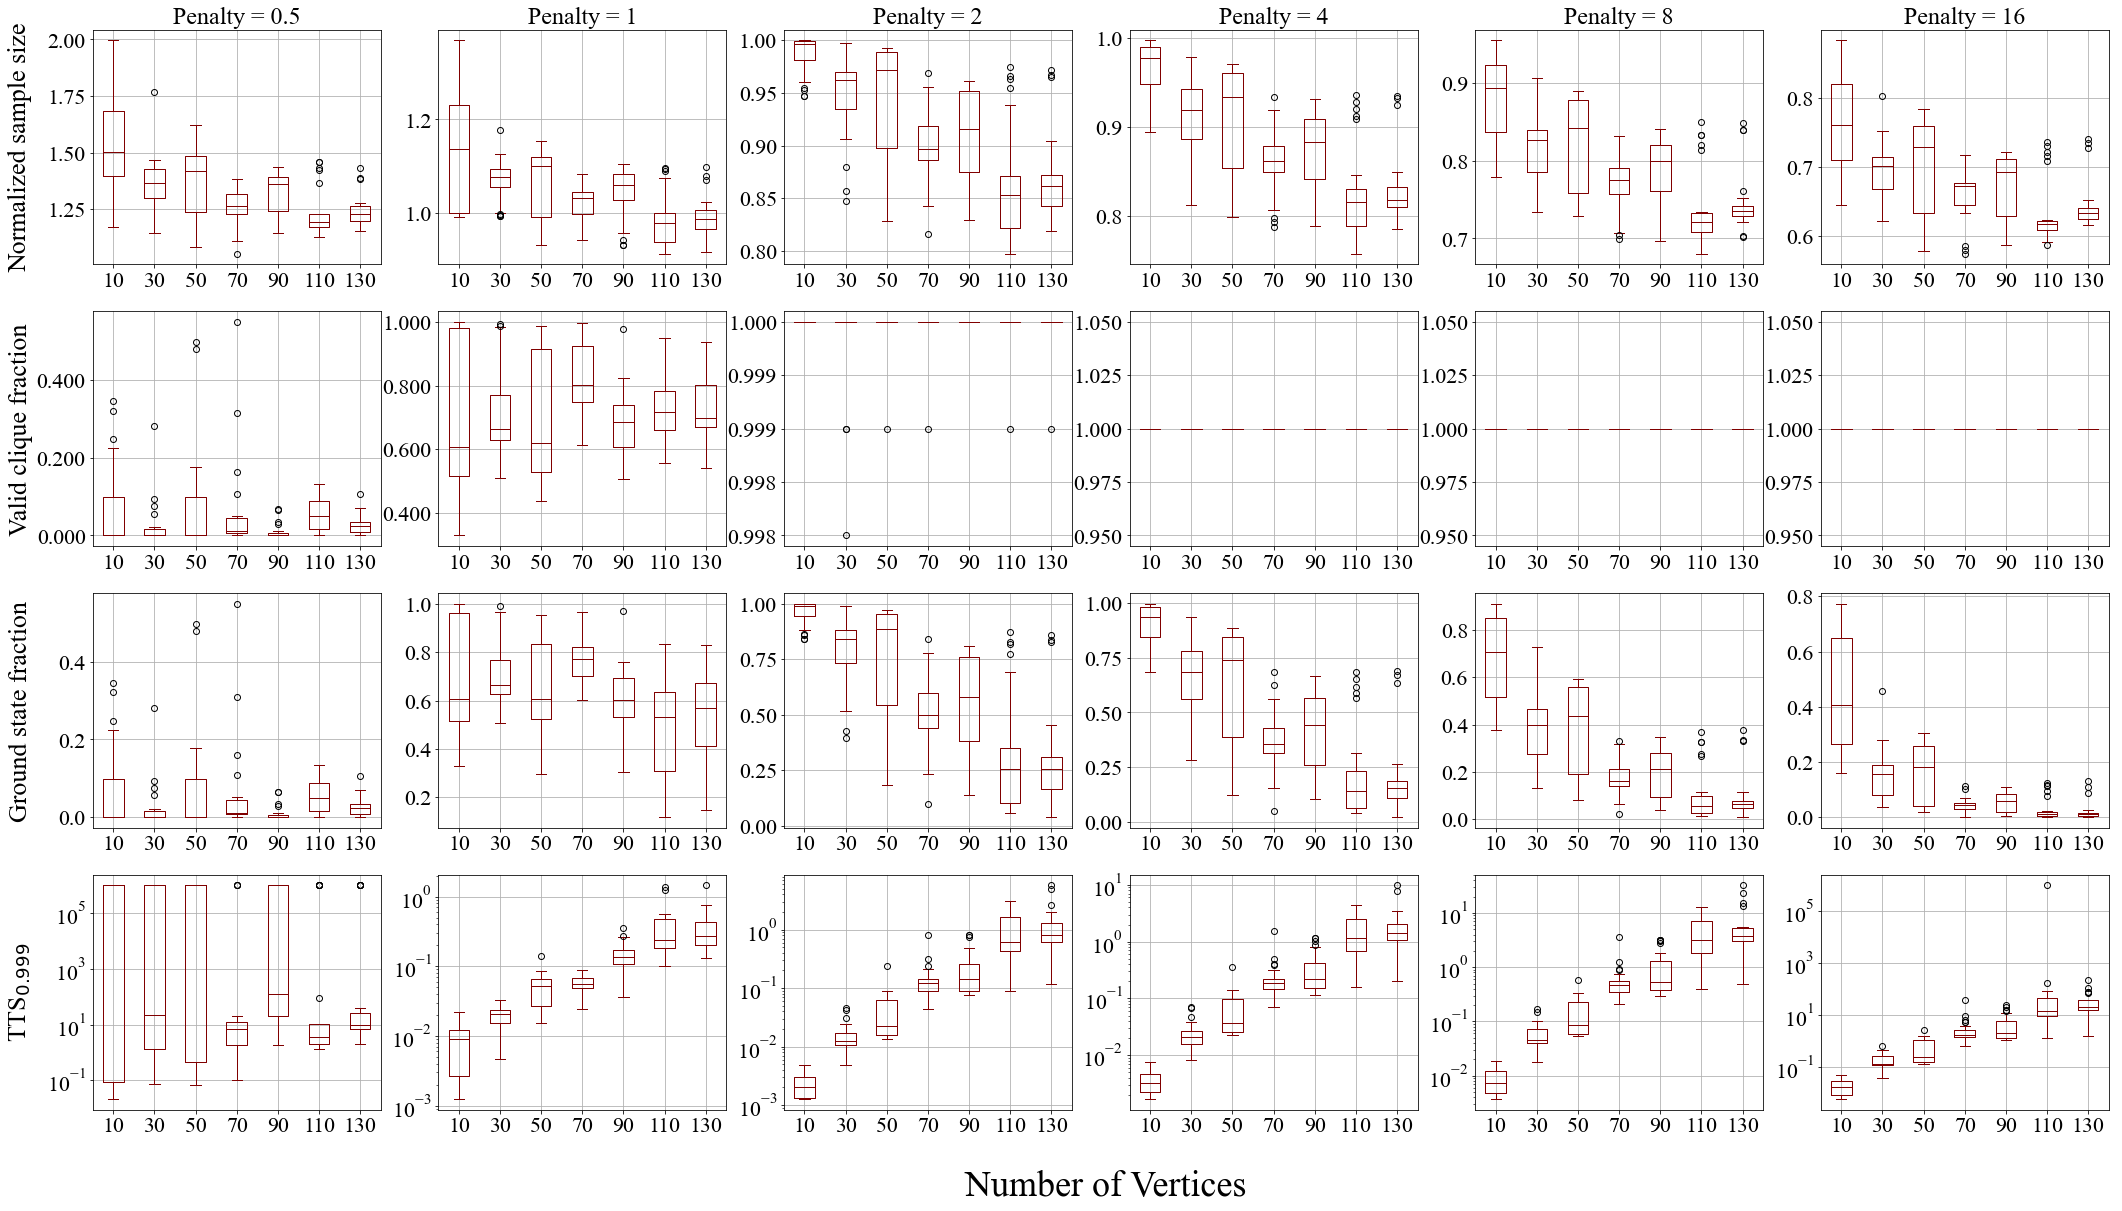

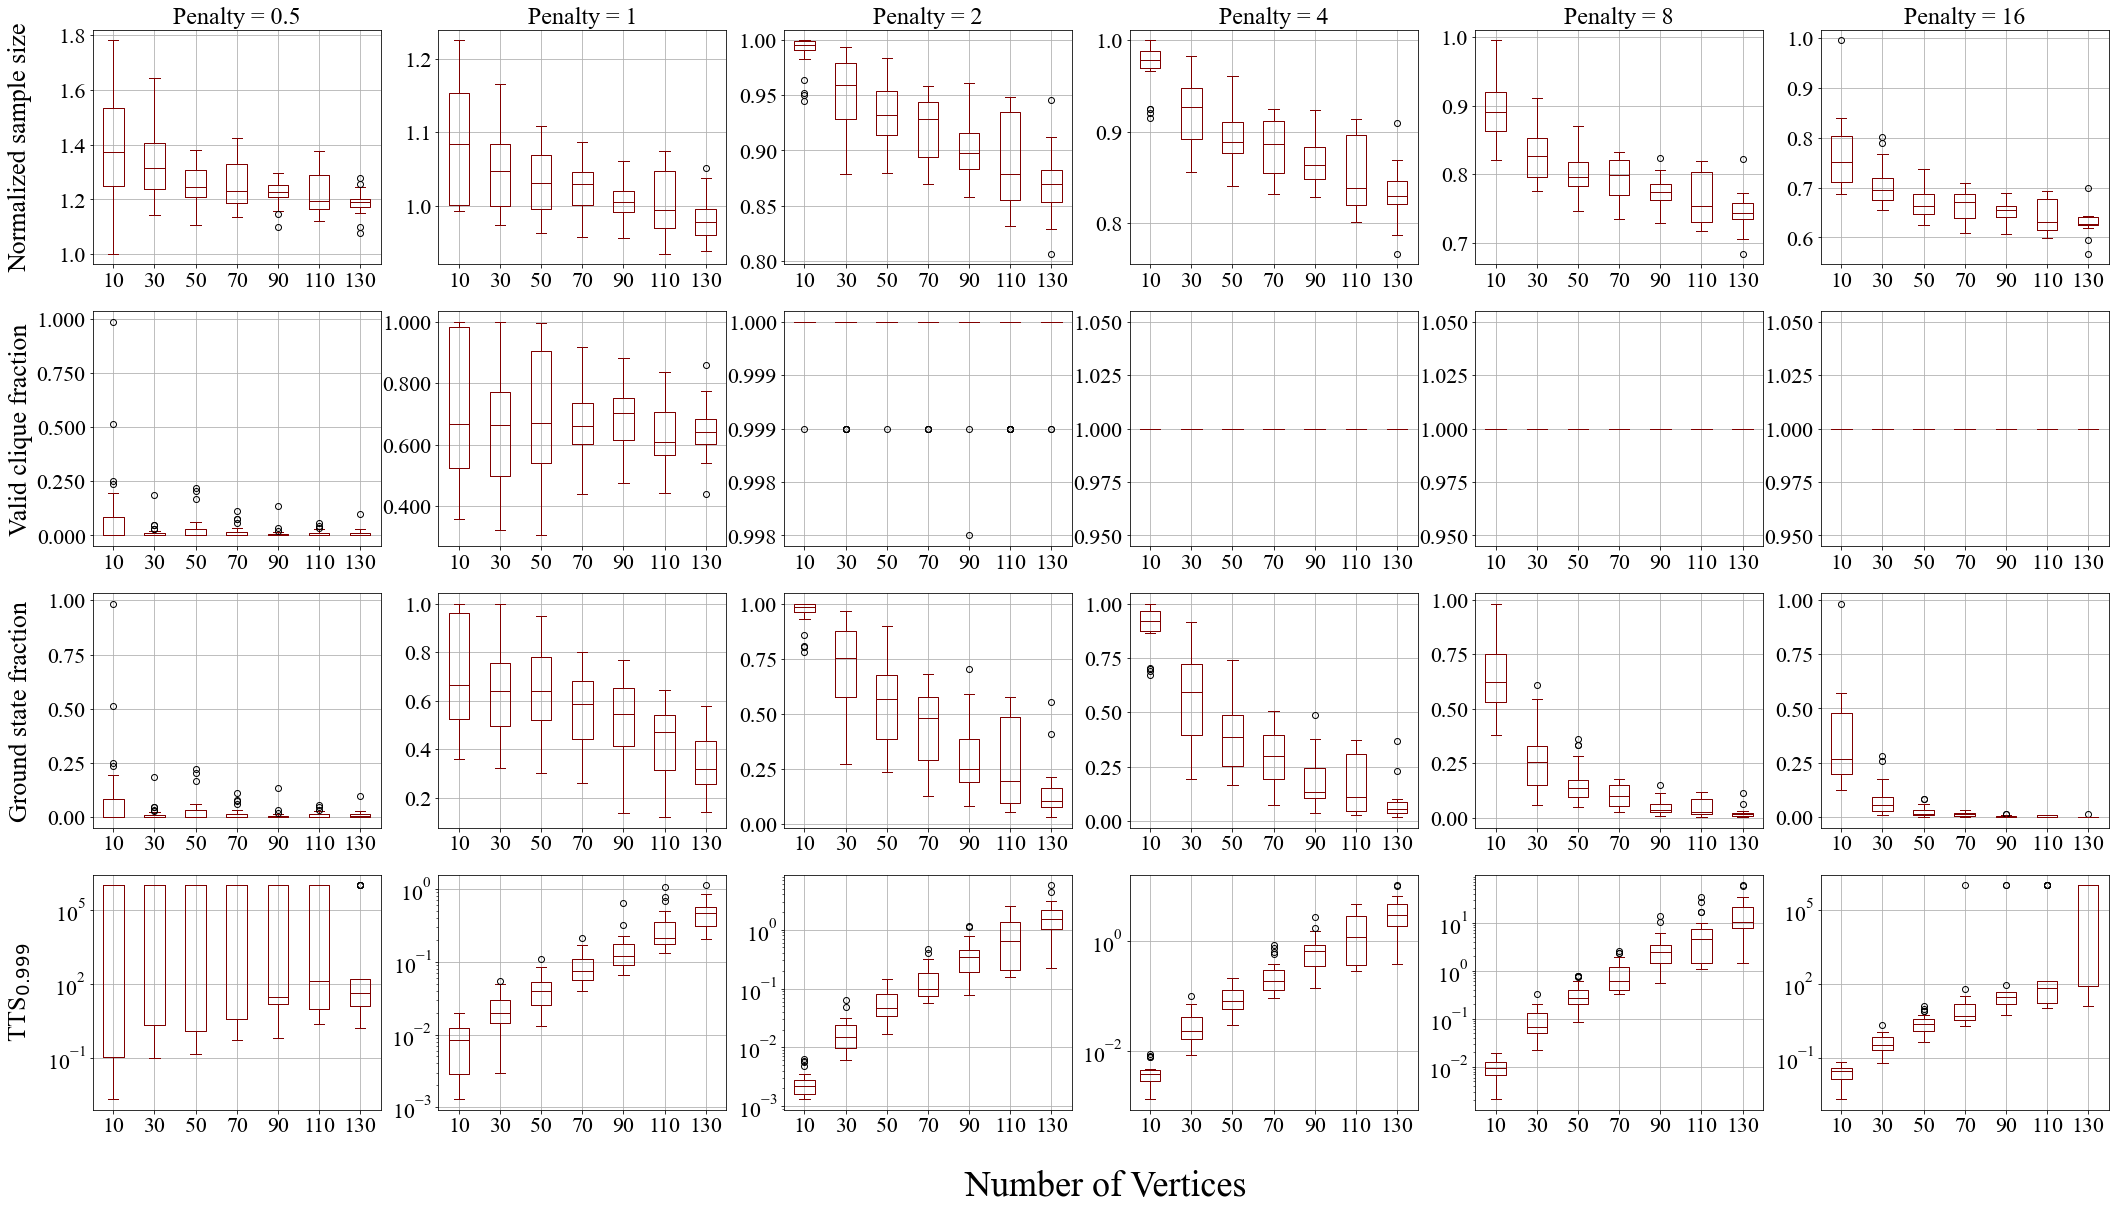

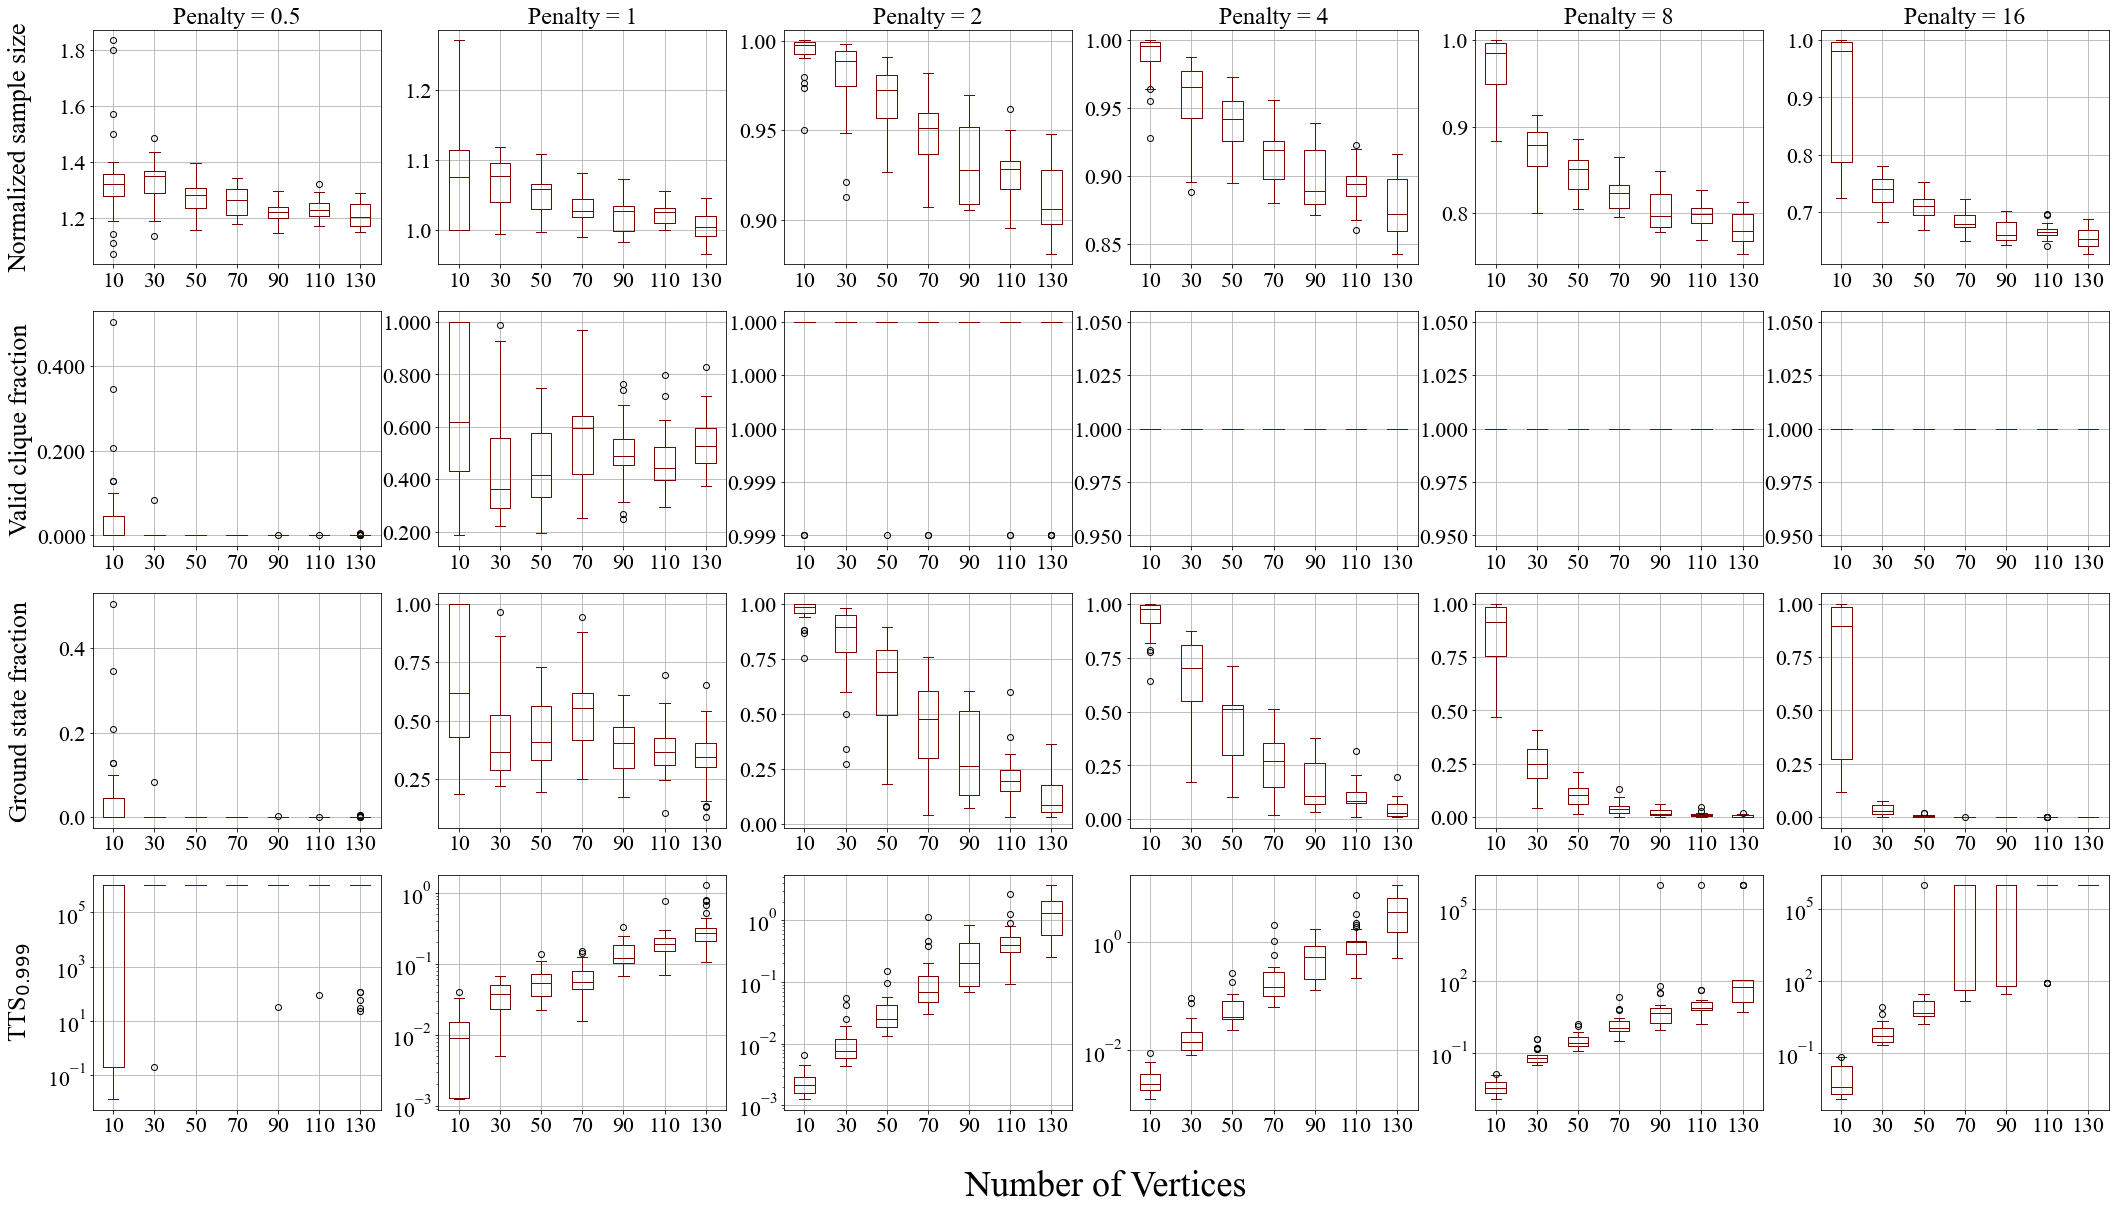

In [13]:
def expand_penalty(df_old):
    record = []
    for _, row in df_old.iterrows():
        N, n, p, n_grid, gp_add_time, gp_mult_time = row['N'], row['n'], row['p'], row['ngrid'],\
        row['gp_add_time'], row['gp_mult_time']
        ss_list = row['ss_list']
        vcc_list = row['vcc_list']
        for idx, penalty_exp in enumerate(range(-1, 5)):
            penalty = 2**penalty_exp

            ss = ss_list[idx] #ss = samplesize
            if ss is None:
                continue
            ss_scaled = ss / row['GT_val']

            vcc = vcc_list[idx]
            valid_gs = vcc * (ss == row['GT_val'])

            mean_time = np.mean(row['t_list'][idx])
            
            def tts_999(vgs):
                if vgs <= 0.:
                    return 1e6
                elif vgs >= 1.:
                    return mean_time
                else:
                    return mean_time * np.log(1 - 0.999) / np.log(1 - vgs)

            record.append((N, n, p, penalty, n_grid, gp_add_time, gp_mult_time,\
                           np.mean(ss_scaled), np.mean(vcc),\
                           np.mean(valid_gs),mean_time, tts_999(np.mean(valid_gs))))
    df = pd.DataFrame.from_records(record,\
                        columns = ['N', 'n','p', 'penalty', 'ngrid', 'gp_add_time',\
                                   'gp_mult_time', 'ss', 'vcc', 'gs_frac','mean_t', 'tts_999'])
    return df


color = 'maroon'
for p_idx in range(3):
    fig, axs = plt.subplots(4, len(range(-1, 5)), figsize = (35, 20))
    df = expand_penalty(dfs[p_idx])
    for idx, penalty_exp in enumerate(range(-1, 5)):
        penalty = 2**penalty_exp

        df_pen = df[df['penalty']==penalty]
        df_pen.boxplot(column='ss', by='n', ax=axs[0, idx], color = color)
        axs[0, idx].set_xlabel('')
        axs[0, idx].set_title('Penalty = {}'.format(penalty), fontsize=24)
        

        df_pen.boxplot(column='vcc', by='n', ax=axs[1, idx], color = color)
        axs[1, idx].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
        axs[1, idx].set_xlabel('')
        axs[1, idx].set_title('')
        

        df_pen.boxplot(column='gs_frac', by='n', ax=axs[2, idx], color = color)
        axs[2, idx].set_xlabel('')
        axs[2, idx].set_title('')
        

        df_pen.boxplot(column='tts_999', by='n', ax=axs[3, idx], color = color)
        axs[3, idx].set_xlabel('')
        axs[3, idx].set_yscale('log')
        axs[3, idx].set_title('')
        
        
        if idx == 0:
            axs[0, idx].set_ylabel('Normalized sample size', fontsize=26)
            axs[1, idx].set_ylabel('Valid clique fraction', fontsize=26)
            axs[2, idx].set_ylabel('Ground state fraction', fontsize=26)
            axs[3, idx].set_ylabel(r'TTS$_{0.999}$', fontsize=26)
    fig.suptitle('')
    fig.align_ylabels(axs)
    
    for idx_i in range(4):
        for idx_j in range(6):
            axs[idx_i, idx_j].tick_params(axis='both', which='major', labelsize=22)
            
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    plt.xlabel('\n Number of Vertices', fontsize=36)
        
    plt.savefig('../plots/neal_max_clique_p={}.pdf'.format(p_vals[p_idx]))

Profile breakdown plot

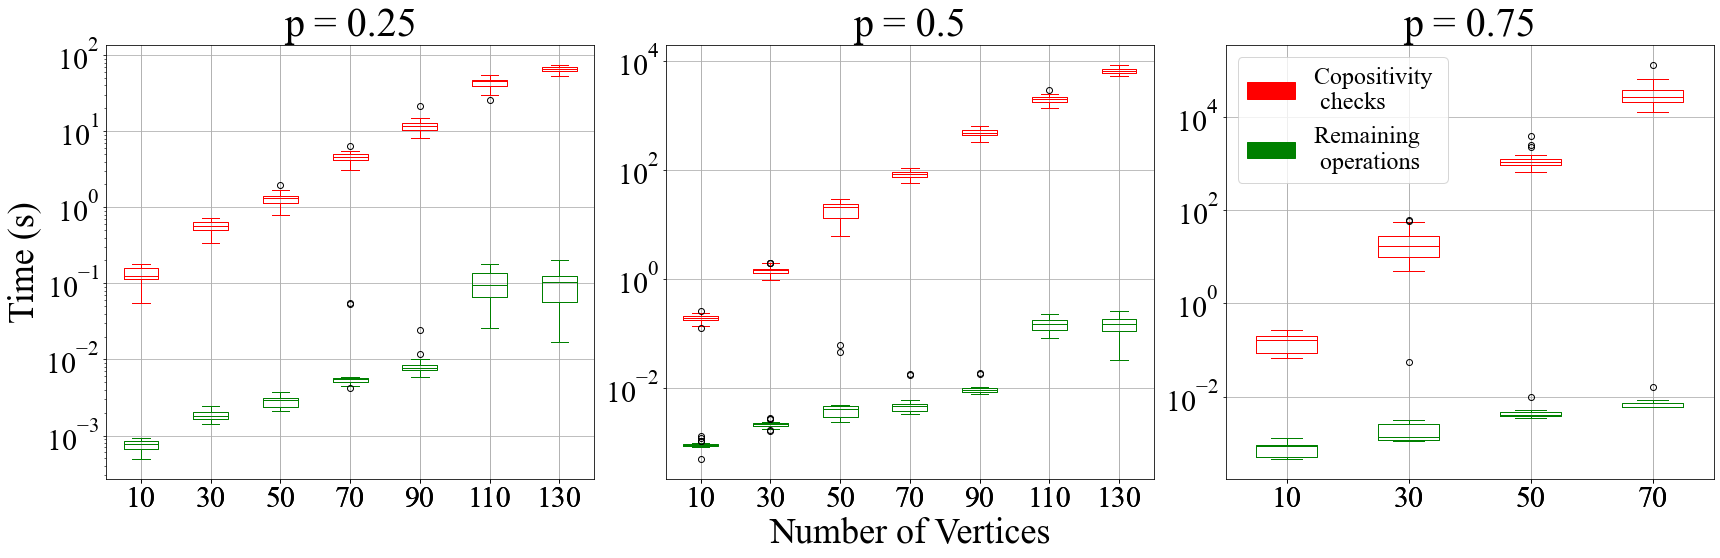

In [14]:
fig, axes = plt.subplots(1, len(p_vals), figsize = (len(p_vals) * 8, 8))
for idx, p in enumerate(p_vals):
    ax = axes[idx]
    df = dfs[idx]
    df['rest_time_gp'] = df['full_time_gp'] - df['cop_times_gp']
    df['rest_time_neal'] = df['full_time_neal'] - df['cop_times_neal']
    df.boxplot(column = 'cop_times_gp', by='n', ax = ax,  color = 'red')
    df.boxplot(column = 'rest_time_gp', by='n', ax = ax,  color='green')
    ax.set_xlabel('')
    ax.set_yscale('log')
    ax.set_title('p = {}'.format(p), fontsize=40)
    ax.tick_params(axis='both', which='major', labelsize=30)
    if idx == 0:
        ax.set_ylabel('Time (s)', fontsize=36)
    if idx == 1:
        ax.set_xlabel('Number of Vertices', fontsize=36)
    if idx == 2:
        ax.set_xlim(right = 4.5)
    
fig.suptitle('')
red_patch = mpatches.Patch(color='red', label='Copositivity \n checks')
green_patch = mpatches.Patch(color='green', label='Remaining \n operations')
plt.legend(handles=[red_patch, green_patch], fontsize=24)
plt.tight_layout()
plt.savefig('../plots/profile_breakdown.pdf')

Plot gurobi vs simulated annealing comparison for copositivity checks

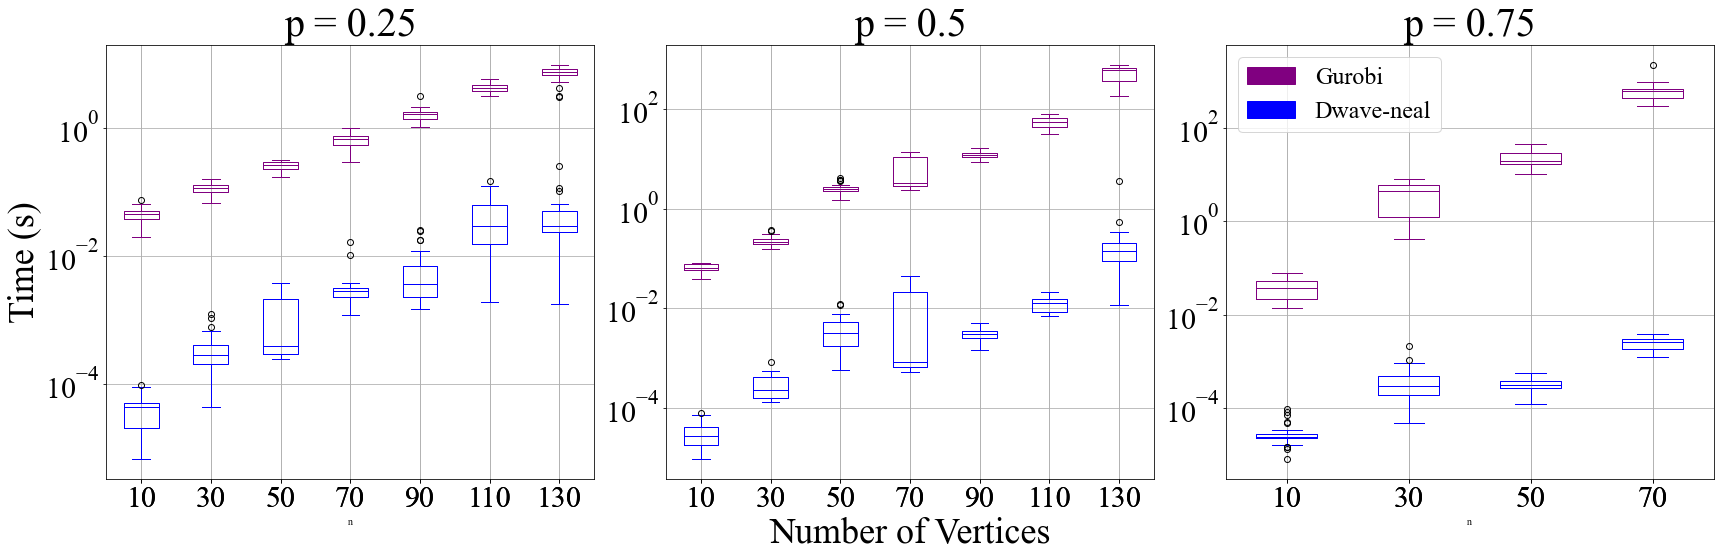

In [15]:
fig, axes = plt.subplots(1, len(p_vals), figsize = (len(p_vals) * 8, 8))
for idx, p in enumerate(p_vals):
    ax = axes[idx]
    df = dfs[idx]
    df.boxplot(column = 'tts_99', by='n', ax=ax, color='blue')
#     df.boxplot(column = 'best_TTS', by='n', ax=ax, color='c')
    df.boxplot(column = 'gp_infeas_time', by='n', ax=ax, color='purple')
    ax.set_yscale('log')
    ax.set_title('p = {}'.format(p), fontsize=40)
    ax.tick_params(axis='both', which='major', labelsize=30)
    if idx == 0:
        ax.set_ylabel('Time (s)', fontsize=36)
    if idx == 1:
        ax.set_xlabel('Number of Vertices', fontsize=36)
        
    if idx == 2:
        ax.set_xlim(right = 4.5)
    
fig.suptitle('')
red_patch = mpatches.Patch(color='purple', label='Gurobi')
blue_patch = mpatches.Patch(color='blue', label='Dwave-neal')
plt.legend(handles=[red_patch, blue_patch], fontsize=24)
plt.tight_layout()
plt.savefig('../plots/gurobi_comparison.pdf')

Plot optimized vs fixed number of sweeps

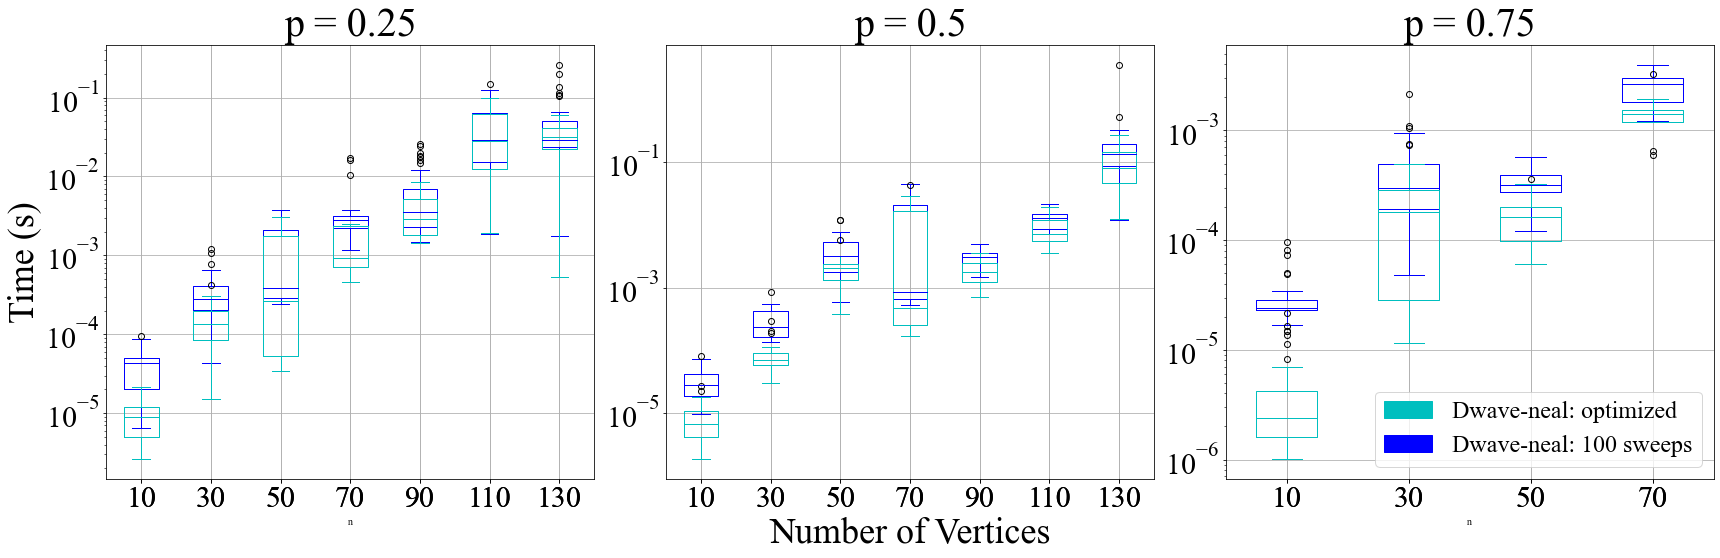

In [16]:
fig, axes = plt.subplots(1, len(p_vals), figsize = (len(p_vals) * 8, 8))
for idx, p in enumerate(p_vals):
    ax = axes[idx]
    df = dfs[idx]
    df.boxplot(column = 'tts_99', by='n', ax=ax, color='blue')
    df.boxplot(column = 'best_TTS', by='n', ax=ax, color='c')
#     df.boxplot(column = 'gp_infeas_time', by='n', ax=ax, color='purple')
    ax.set_yscale('log')
    ax.set_title('p = {}'.format(p), fontsize=40)
    ax.tick_params(axis='both', which='major', labelsize=30)
    if idx == 0:
        ax.set_ylabel('Time (s)', fontsize=36)
    if idx == 1:
        ax.set_xlabel('Number of Vertices', fontsize=36)
        
    if idx == 2:
        ax.set_xlim(right = 4.5)
    
fig.suptitle('')
c_patch = mpatches.Patch(color='c', label='Dwave-neal: optimized')
blue_patch = mpatches.Patch(color='blue', label='Dwave-neal: 100 sweeps')
plt.legend(handles=[c_patch, blue_patch], fontsize=24)
plt.tight_layout()
plt.savefig('../plots/opt_comparison.pdf')

Plot best sweep values

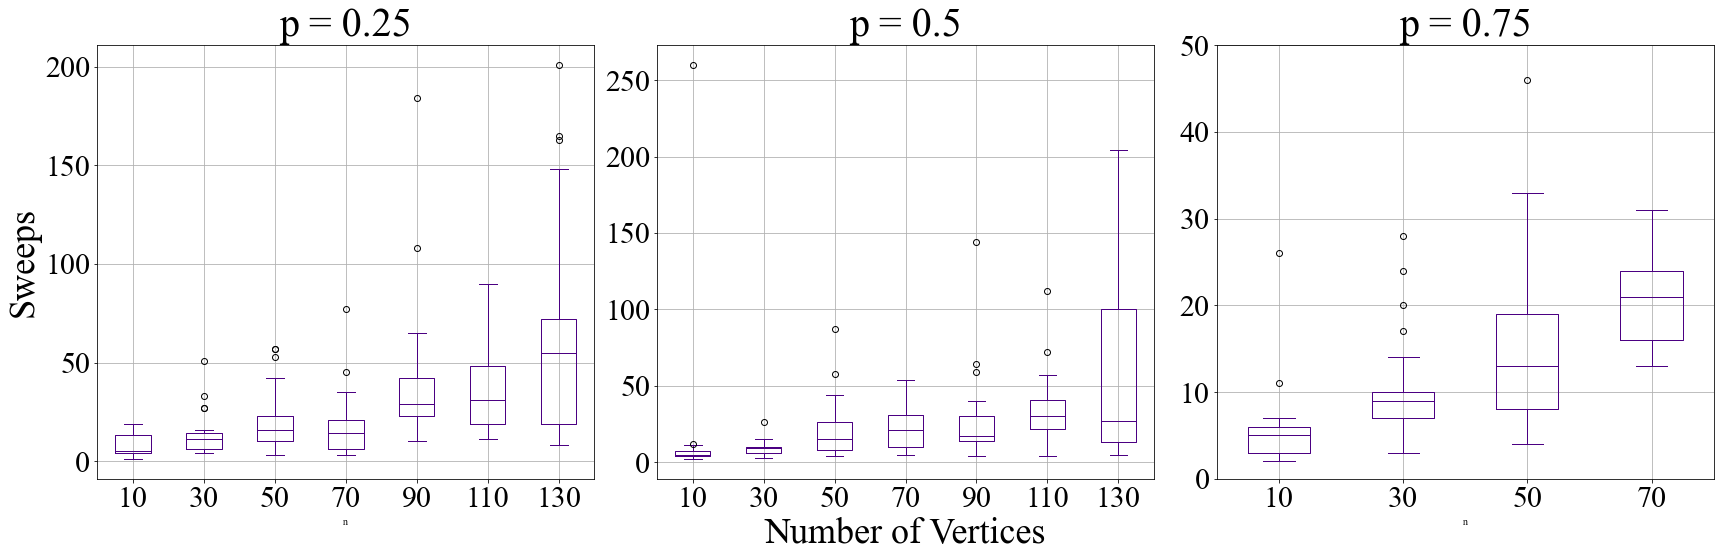

In [17]:
def best_swe(row):
    if math.isnan(row['best_TTS']):
        return None
    idx = row['TTS'].index(row['best_TTS'])
    return row['swe_list'][idx]

fig, axes = plt.subplots(1, len(p_vals), figsize = (len(p_vals) * 8, 8))
for idx, p in enumerate(p_vals):
    ax = axes[idx]
    df = dfs[idx]
    df['best_swe'] = df.apply(best_swe, axis=1)
    df.boxplot(column = 'best_swe', by='n', ax=ax, color='indigo')
    ax.set_title('p = {}'.format(p), fontsize=40)
    ax.tick_params(axis='both', which='major', labelsize=30)
    if idx == 0:
        ax.set_ylabel('Sweeps', fontsize=36)
    if idx == 1:
        ax.set_xlabel('Number of Vertices', fontsize=36)
        
    if idx == 2:
        ax.set_ylim([0, 50])
        ax.set_xlim(right = 4.5)
    
fig.suptitle('')
plt.tight_layout()
plt.savefig('../plots/opt_sweeps.pdf')

Plot bounds with TTS 

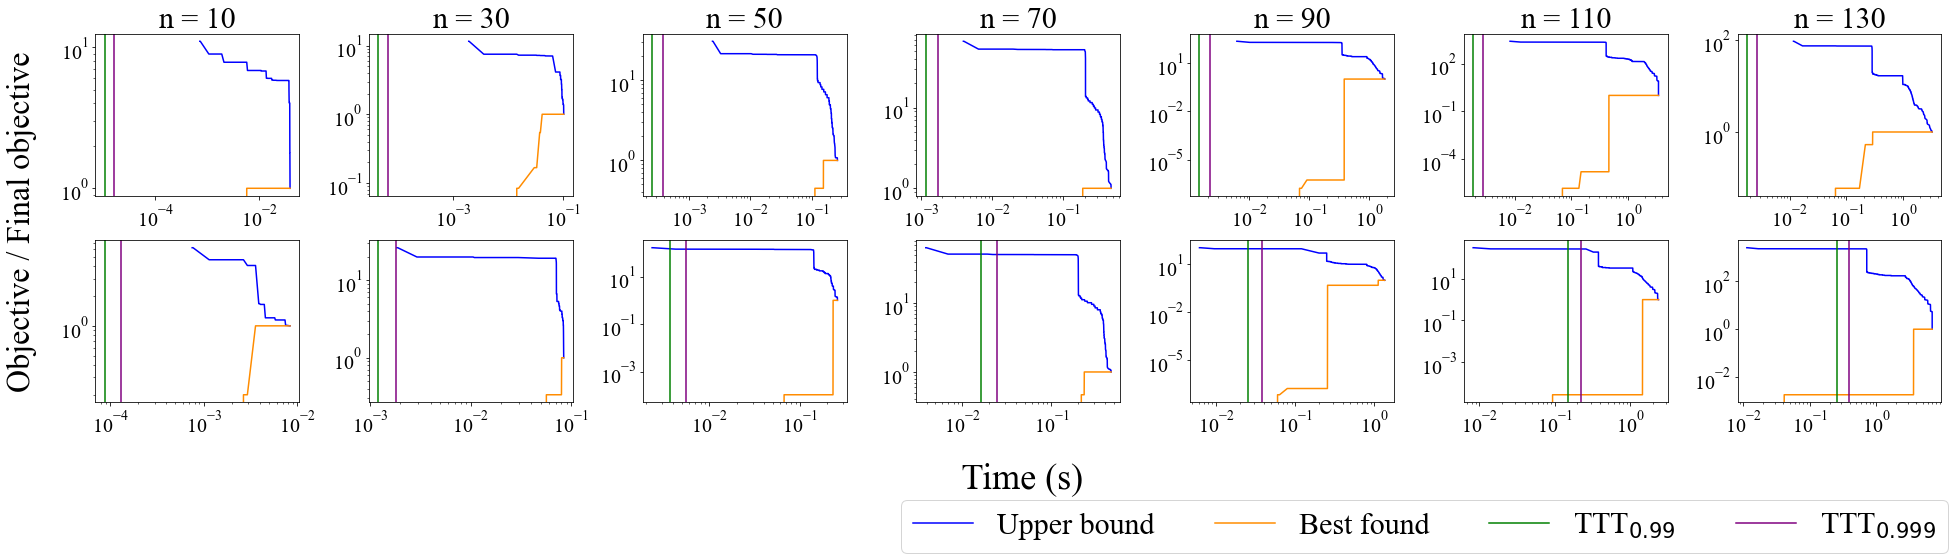

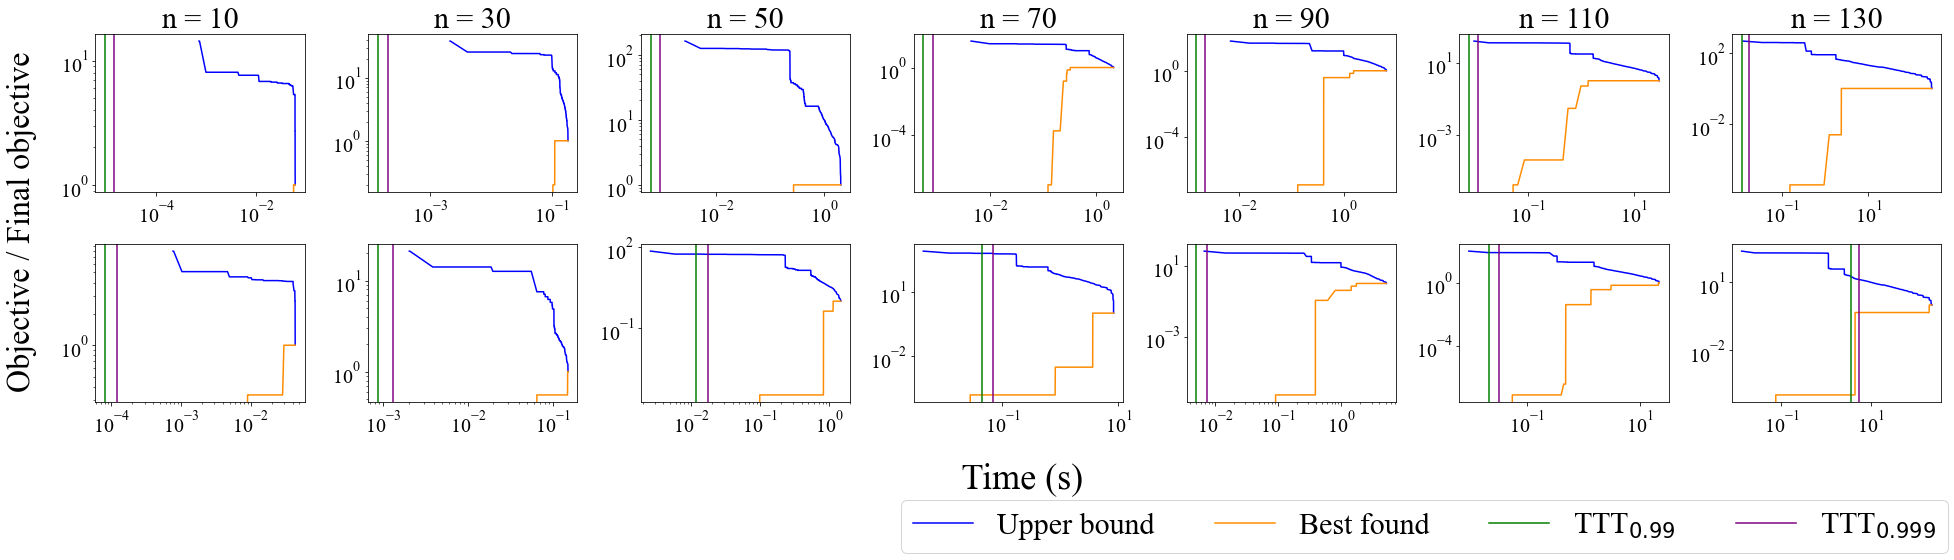

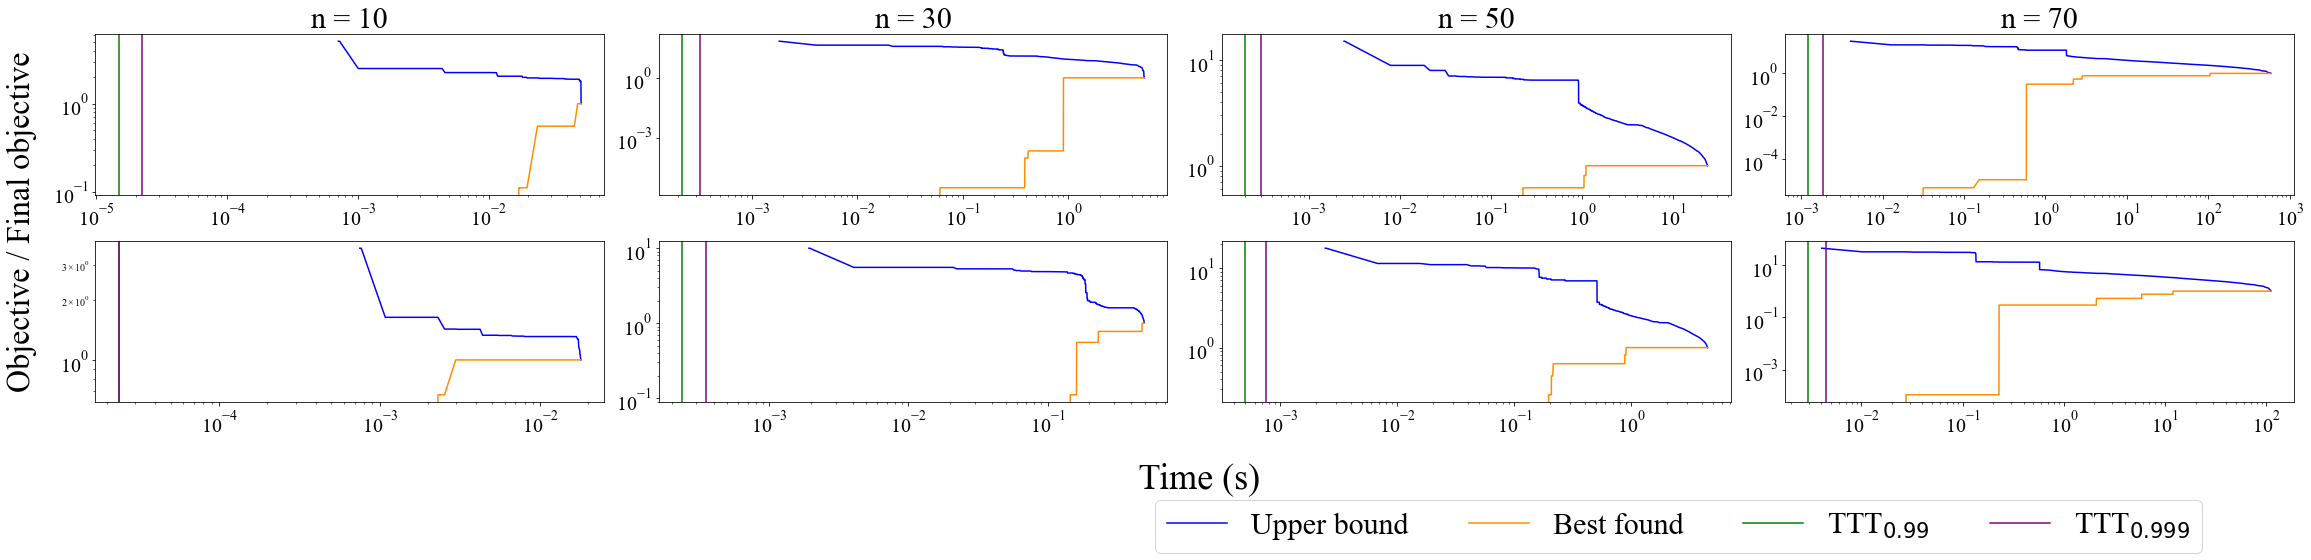

In [18]:
for idx_p, p in enumerate(p_vals):
    if idx_p == 2:
        nvs = range(10, 80, 20)
        fig, axes = plt.subplots(2, len(nvs), figsize = (len(nvs) * 8.2, 9.25))
    else:
        nvs = range(10, 140, 20)
        fig, axes = plt.subplots(2, len(nvs), figsize = (len(nvs) * 4.1, 9.25))
    
    for idx, nv in enumerate(nvs):
        df = dfs[idx_p][dfs[idx_p]['n'] == nv]
        max_idx = (df['gp_infeas_time'] / df['tts_99']).idxmax()
        min_idx = (df['gp_infeas_time'] / df['tts_99']).idxmin()
        
        row = dfs[idx_p].iloc[max_idx]
        ax = axes[0, idx]
        if len(row['gp_t']) == 1:
            ub = ax.scatter(row['gp_t'], row['gp_ub'], c='blue', label = 'Upper bound')
            lb = ax.scatter(row['gp_t'], row['gp_best'], c='darkorange', label = 'Best bound')
        else:
            ub, = ax.plot(row['gp_t'], row['gp_ub'], c='blue', label = 'Upper bound')
            lb, = ax.plot(row['gp_t'], row['gp_best'], c='darkorange', label = 'Best bound')


        tts_99 = ax.axvline(row['tts_99'], c='green', label=r'TTT$_{0.99}$')
        tts_999 = ax.axvline(row['tts_999'],c='purple', label=r'TTT$_{0.999}$')
        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.tick_params(axis='both', which='major', labelsize=20)
        ax.set_title('n = {}'.format(row['n']), fontsize=30)

        row = dfs[idx_p].iloc[min_idx]
        ax = axes[1, idx]
        if len(row['gp_t']) == 1:
            ub = ax.scatter(row['gp_t'], row['gp_ub'], c='blue', label = 'Upper bound')
            lb = ax.scatter(row['gp_t'], row['gp_best'], c='darkorange', label = 'Best bound')
        else:
            ub, = ax.plot(row['gp_t'], row['gp_ub'], c='blue', label = 'Upper bound')
            lb, = ax.plot(row['gp_t'], row['gp_best'], c='darkorange', label = 'Best bound')
        tts_99 = ax.axvline(row['tts_99'], c='green', label=r'TTT$_{0.99}$')
        tts_999 = ax.axvline(row['tts_999'],c='purple', label=r'TTT$_{0.999}$')
        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.tick_params(axis='both', which='major', labelsize=20)
        
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    plt.xlabel('\n Time (s)', fontsize=36)
    plt.ylabel('Objective / Final objective \n', fontsize=32)
    
    plt.legend((ub, lb, tts_99, tts_999),\
              ('Upper bound', 'Best found',r'TTT$_{0.99}$',r'TTT$_{0.999}$'),\
               loc = 'lower center', fontsize=30, bbox_to_anchor=(0.72, -0.45), ncol=4)
    plt.tight_layout()
#     plt.savefig('../plots/gurobi_bds_p={}.pdf'.format(p))


Plot instance with gap closed in first callback

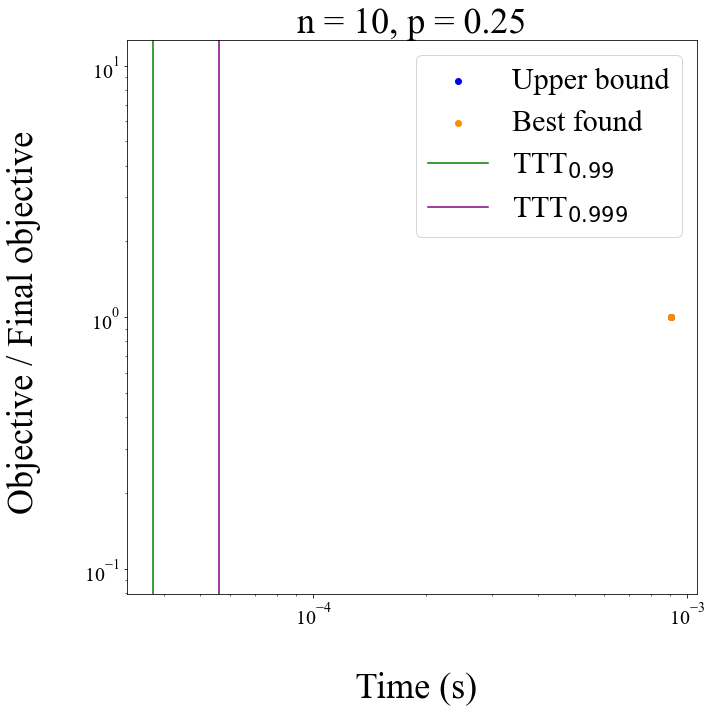

In [19]:
def length(row):
    if row['gp_t'] is None:
        return 0
    else:
        return len(row['gp_t'])
for idx_p, p in enumerate(p_vals):
    df = dfs[idx_p]
    one_idx = [idx for idx, row in df.iterrows() if length(row) == 1]
    for idx_1 in one_idx:
        fig = plt.figure(figsize=(10, 10))
        ax  = plt.gca()

        row = df.iloc[idx_1]
        ub = ax.scatter(row['gp_t'], row['gp_ub'], c='blue', label = 'Upper bound')
        lb = ax.scatter(row['gp_t'], row['gp_best'], c='darkorange', label = 'Best bound')
        tts_99 = ax.axvline(row['tts_99'], c='green', label='s = 0.99')
        tts_999 = ax.axvline(row['tts_999'],c='purple', label='s = 0.999')
        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.tick_params(axis='both', which='major', labelsize=20)
        ax.set_title('n = {}, p = {}'.format(row['n'], row['p']), fontsize=36)

        ax.set_xlabel('\n Time (s)', fontsize=36)
        ax.set_ylabel('Objective / Final objective \n', fontsize=36)

        plt.legend((ub, lb, tts_99, tts_999),\
                  ('Upper bound', 'Best found',r'TTT$_{0.99}$',r'TTT$_{0.999}$'), fontsize=30)
        plt.tight_layout()
#         plt.savefig('../plots/first_guess_n={}_p={}.pdf'.format(row['n'], row['p']))

